# AIN433- Assignment 3

### Name : Emre Çoban
### ID : 2200765028

In [18]:
# Import necessary libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import warnings
import time
warnings.filterwarnings("ignore")

## Keypoint Extraction

In [19]:
def extract_keypoints(image, method='sift'):
    """
    Extracts keypoints and descriptors from an input image using specified keypoint extraction method.

    Parameters:
        image (numpy.ndarray): The input image for which keypoints and descriptors need to be extracted.
        method (str): The keypoint extraction method to use. Default is 'sift'. Options: 'sift' or 'orb'.

    Returns:
        tuple: A tuple containing two elements - keypoints and descriptors.
            - keypoints: A list of keypoint objects detected in the image.
            - descriptors: The computed descriptors corresponding to the keypoints.
    """
    # Check the specified method and create the corresponding object
    if method == 'sift':
        keypoint_extractor = cv2.SIFT_create()
    elif method == 'orb':
        keypoint_extractor = cv2.ORB_create(nfeatures=5000) # It can detect up to 5000 kp
    else:
        raise ValueError('Invalid keypoint extraction method specified')

    # Detect and compute keypoints and descriptors
    keypoints, descriptors = keypoint_extractor.detectAndCompute(image, None)

    # Return the keypoints and descriptors
    return keypoints, descriptors

## Keypoint Matching

In [20]:
def match_keypoints(descriptors1, descriptors2):
    """
    Matches keypoints between two sets of descriptors using a Brute-Force Matcher.

    Parameters:
        descriptors1 (numpy.ndarray): Descriptors from the first set of keypoints.
        descriptors2 (numpy.ndarray): Descriptors from the second set of keypoints.

    Returns:
        list: A list of good matches between the two sets of keypoints.
    """
    # Create a Brute-Force Matcher
    bf = cv2.BFMatcher()

    # Use the matcher to find k=2 nearest matches for each descriptor
    matches = bf.knnMatch(descriptors1, descriptors2, k=2)

    # Filter good matches based on the distance ratio test
    good_matches = []
    for m, n in matches:
        if m.distance < 0.75 * n.distance:
            good_matches.append(m)

    # Return the list of good matches
    return good_matches

### Comparing speed and number of keypoints detected with SIFT and ORB

In [26]:
# Read the images
im1 = cv2.imread("dataset/goldengate/01.png")
im2 = cv2.imread("dataset/goldengate/02.png")

# Extract keypoints and descriptors using SIFT
start_time = time.time()
keypoints_sift, descriptors_sift = extract_keypoints(im1, method='sift')
time_sift_extraction = time.time() - start_time
print(f"SIFT - Number of keypoints: {len(keypoints_sift)}, Extraction Time: {time_sift_extraction:.4f} seconds")

# Extract keypoints and descriptors using ORB
start_time = time.time()
keypoints_orb, descriptors_orb = extract_keypoints(im1, method='orb')
time_orb_extraction = time.time() - start_time
print(f"ORB - Number of keypoints: {len(keypoints_orb)}, Extraction Time: {time_orb_extraction:.4f} seconds")

# Extract keypoints and descriptors for SIFT and ORB separately
sift_keypoints_im1, siftdesc1 = extract_keypoints(im1, "sift")
orb_keypoints_im1, orbdesc1 = extract_keypoints(im1, "orb")

sift_keypoints_im2, siftdesc2 = extract_keypoints(im2, "sift")
orb_keypoints_im2, orbdesc2 = extract_keypoints(im2, "orb")

# Match keypoints using SIFT
start_time = time.time()
sift_matches = match_keypoints(siftdesc1, siftdesc2)
time_sift_matching = time.time() - start_time
print(f"SIFT - Number of matches: {len(sift_matches)}, Matching Time: {time_sift_matching:.4f} seconds")


# Match keypoints using ORB
start_time = time.time()
orb_matches = match_keypoints(orbdesc1, orbdesc2)
time_orb_matching = time.time() - start_time
print(f"ORB - Number of matches: {len(orb_matches)}, Matching Time: {time_orb_matching:.4f} seconds")

SIFT - Number of keypoints: 2735, Extraction Time: 0.0651 seconds
ORB - Number of keypoints: 4501, Extraction Time: 0.0100 seconds
SIFT - Number of matches: 835, Matching Time: 0.0220 seconds
ORB - Number of matches: 556, Matching Time: 0.0295 seconds


Even though ORB might be faster and might find more keypoints compared to SIFT. I preferred SIFT because it is able to find more matches afterwards which would be usefull later on when calculating homography matrix.

# Homography Using Ransac

In [6]:
def calculate_homography(keypoints1, keypoints2, matches, num_iterations=100, inlier_threshold=5.0):
    """
    Calculate homography matrix using RANSAC.

    Parameters:
    - keypoints1 (list): Keypoints from the first image.
    - keypoints2 (list): Keypoints from the second image.
    - matches (list): Correspondences between keypoints.
    - num_iterations (int): Number of RANSAC iterations.
    - inlier_threshold (float): Threshold to consider a match as an inlier.

    Returns:
    Tuple[numpy.ndarray, list]:
    - best_H (numpy.ndarray): Best homography matrix.
    - matches (list): Inlier matches used for calculating homography.
    """
    best_H = None
    max_inliers = 0

    # Check if there are enough matches to calculate homography
    if len(matches) < 6:
        raise ValueError("Need more than 6 matches to calculate homography")

    for _ in range(num_iterations):
        # Randomly sample 4 correspondences
        sample_indices = np.random.choice(len(matches), 4, replace=False)
        sampled_matches = [matches[i] for i in sample_indices]

        # Extract source and destination points for the sampled matches
        src_pts = np.float32([keypoints1[m.queryIdx].pt for m in sampled_matches]).reshape(-1, 1, 2)
        dst_pts = np.float32([keypoints2[m.trainIdx].pt for m in sampled_matches]).reshape(-1, 1, 2)

        # Create matrix A
        A = np.array([[-x, -y, -1, 0, 0, 0, x*u, y*u, u] for (x, y), (u, v) in zip(src_pts[:, 0], dst_pts[:, 0])])
        A = np.vstack([A, np.array([[0, 0, 0, -x, -y, -1, x*v, y*v, v] for (x, y), (u, v) in zip(src_pts[:, 0], dst_pts[:, 0])])])

        # Perform SVD
        _, _, V = np.linalg.svd(A)

        # The homography matrix is the last column of V
        H = V[-1, :].reshape(3, 3)

        # Normalize homography matrix
        H /= H[2, 2]

        # Count inliers
        inliers = sum(1 for match in matches if np.linalg.norm(perspective_transform(np.float32([keypoints1[match.queryIdx].pt]), H) - np.float32([keypoints2[match.trainIdx].pt])) < inlier_threshold)


        # Update the best homography if needed
        if inliers > max_inliers:
            max_inliers = inliers
            best_H = H

    return best_H, matches


## Stitching Part

In [7]:
def merge_images(img1, img2, H):
    """
    Merge two images using a homography matrix.

    Args:
        img1 (numpy.ndarray): First input image.
        img2 (numpy.ndarray): Second input image.
        H (numpy.ndarray): Homography matrix for perspective transformation.

    Returns:
        numpy.ndarray: Final stitched image.
    """

    # Get the dimensions of the input images
    h1, w1 = img1.shape[:2]
    h2, w2 = img2.shape[:2]

    # Define the corners of a rectangle for both images
    corners1 = np.float32([[0, 0], [0, h1], [w1, h1], [w1, 0]]).reshape(-1, 1, 2)
    corners2 = np.float32([[0, 0], [0, h2], [w2, h2], [w2, 0]]).reshape(-1, 1, 2)


    # Warp the corners of the second image using the provided homography matrix H
    warped_corners2 = perspective_transform(corners2.reshape(-1,2), H)

    warped_corners2 = warped_corners2.reshape(-1,1,2)
    # Concatenate the corners of both images
    corners = np.concatenate((corners1, warped_corners2), axis=0)

    # Calculate the minimum and maximum coordinates to define the bounding box
    [xmin, ymin] = np.int32(corners.min(axis=0).ravel() - 0.5)
    [xmax, ymax] = np.int32(corners.max(axis=0).ravel() + 0.5)

    # Translate the bounding box to the positive quadrant
    t = [-xmin, -ymin]
    Ht = np.array([[1, 0, t[0]], [0, 1, t[1]], [0, 0, 1]])

    # Warp the second image to the perspective of the first image
    warped_img2 = cv2.warpPerspective(img2, Ht @ H, (xmax - xmin, ymax - ymin))

    # Place the first image on top of the warped second image in the appropriate location
    warped_img2[t[1]:h1 + t[1], t[0]:w1 + t[0]] = img1

    # Return the final stitched image
    return warped_img2


def perspective_transform(points, M):
    """
    Apply perspective transformation to a set of points.

    Args:
        points (numpy.ndarray): Input points.
        M (numpy.ndarray): Perspective transformation matrix.

    Returns:
        numpy.ndarray: Transformed points.
    """

    # Convert points to homogeneous coordinates
    homogeneous_points = np.hstack((points, np.ones((len(points), 1))))

    # Apply the perspective transformation matrix M
    transformed_points = np.dot(homogeneous_points, M.T)

    # Convert back to non-homogeneous coordinates
    transformed_points = transformed_points[:, :2] / transformed_points[:, 2:]

    return transformed_points


def trim(frame):
    """
    Trim the borders of an image based on zero-valued pixels.

    Args:
        frame (numpy.ndarray): Input image.

    Returns:
        numpy.ndarray: Trimmed image.
    """

    #crop top
    if not np.sum(frame[0]):
        return trim(frame[1:])
    #crop bottom
    elif not np.sum(frame[-1]):
        return trim(frame[:-1])
    #crop left
    elif not np.sum(frame[:,0]):
        return trim(frame[:,1:])
    #crop right
    elif not np.sum(frame[:,-1]):
        return trim(frame[:,:-1])
    return frame



In [8]:
def process_folder(folder, num_images):
    """
    Process images in a given folder to create a stitched panorama.

    Parameters:
    - folder (str): Path to the folder containing images.
    - num_images (int): Number of Images to loop

    Returns:
    None
    """
    # Read the images from the given folder
    images = read_images(folder)

    panoramic_img = images[0]
    intermediate_results_folder = os.path.join(folder, "intermediate_results")
    os.makedirs(intermediate_results_folder, exist_ok=True)

    for idx, image in enumerate(images[1:num_images], start=1):

        # Extract features and draw matches
        panoramic_kp, panoramic_ds = extract_keypoints(panoramic_img)
        new_kp, new_ds = extract_keypoints(image)
        matches = match_keypoints(panoramic_ds, new_ds)

        # Calculate homography and inliers
        h_matrix, inliers = calculate_homography(panoramic_kp, new_kp, matches, num_iterations=1000, inlier_threshold=5)

        # Create a panorama by stitching the images
        image_stitched = trim(merge_images( image,panoramic_img, h_matrix))

        # Update the left image for the next iteration
        panoramic_img = image_stitched


        # Save only at the first step and last step
        if idx == 1 or idx == num_images - 1 :

            # Create a figure with one row and four columns
            fig, axs = plt.subplots(1, 4, figsize=(15, 5))
            # Plot the old image
            axs[0].imshow(cv2.drawKeypoints(panoramic_img, panoramic_kp, None, color=(0, 255, 0)))
            axs[0].set_title('Old Panoramic Image Keypoints')

            # Plot the new image
            axs[1].imshow(cv2.drawKeypoints(image, new_kp, None, color=(0, 255, 0)))
            axs[1].set_title('New Image Keypoints')

            # Draw matches on a new image
            img_matches = cv2.drawMatches(panoramic_img, panoramic_kp, image, new_kp, matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
            axs[2].imshow(img_matches)
            axs[2].set_title('Feature Matches')


            # Plot the stitched image
            axs[3].imshow(image_stitched)
            axs[3].set_title("Stitched Image")

            plt.tight_layout()
            figure_path = os.path.join(intermediate_results_folder, f'step_{idx}.png')
            plt.savefig(figure_path)
            plt.show()

    # Save the final panorama
    save_path = os.path.join(folder, 'result.png')
    cv2.imwrite(save_path, panoramic_img)

## Lets start stitching images from dataset

In [9]:
# Specify the dataset main path
dataset_directory = os.path.join(os.getcwd(), 'dataset')
print(f"Dataset directory: {dataset_directory}")

def read_images(folder_path):

    images = []
    # Iterate over the specified folder to read each image one by one
    for file in os.listdir(folder_path):

        # Get the path of the specified image, then read it as a numpy array and store it in the images_array list
        image_path = os.path.join(folder_path, file)
        image = cv2.imread(image_path)
        images.append(image)

    images = np.array(images)
    return images

Dataset directory: C:\Users\user\PycharmProjects\AIN433-A3\dataset


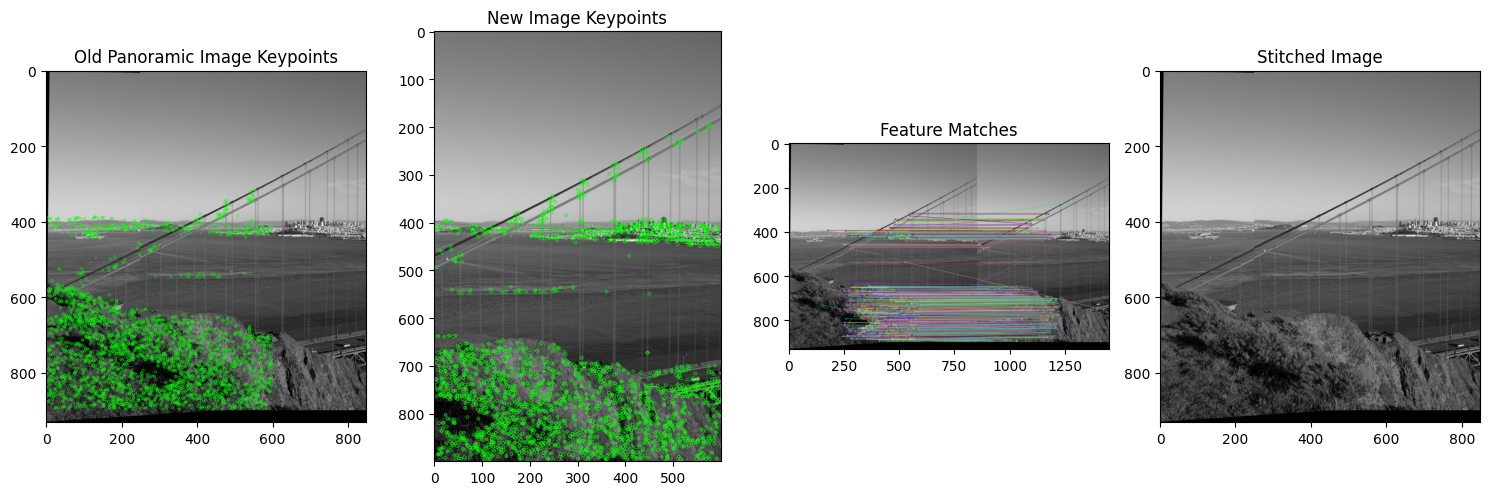

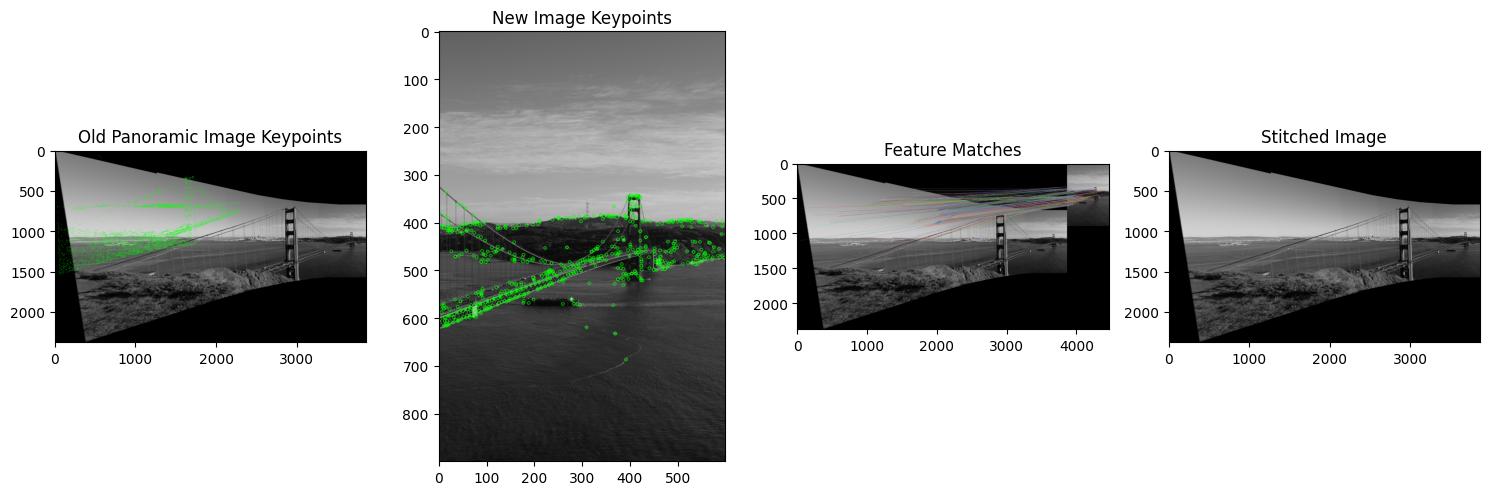

In [9]:
process_folder(os.path.join(dataset_directory, 'goldengate'),6)

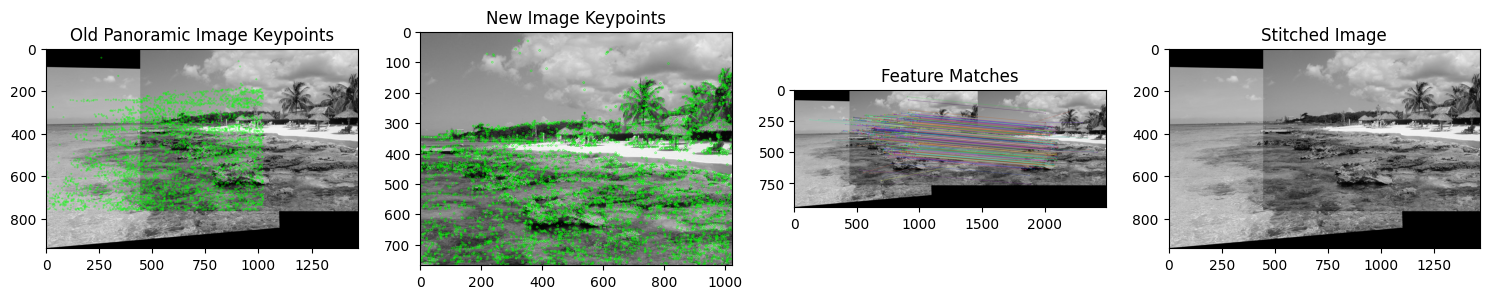

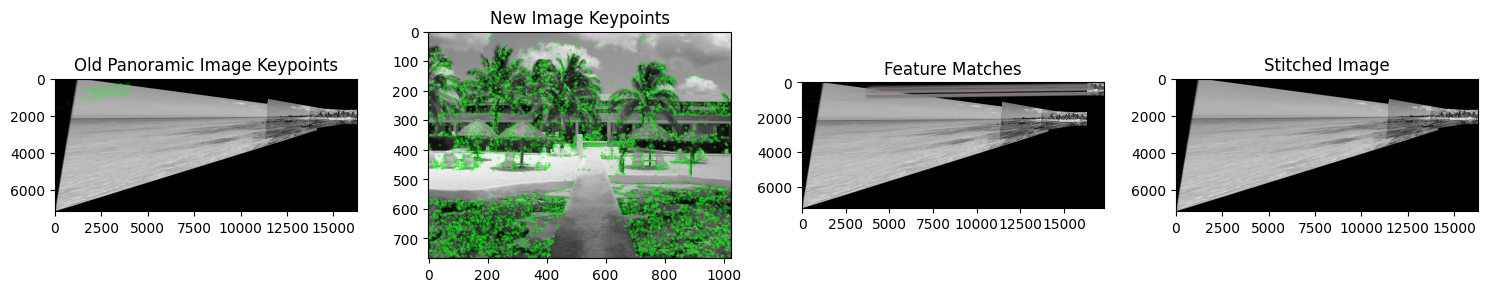

In [10]:
process_folder(os.path.join(dataset_directory, 'hotel'), 5)

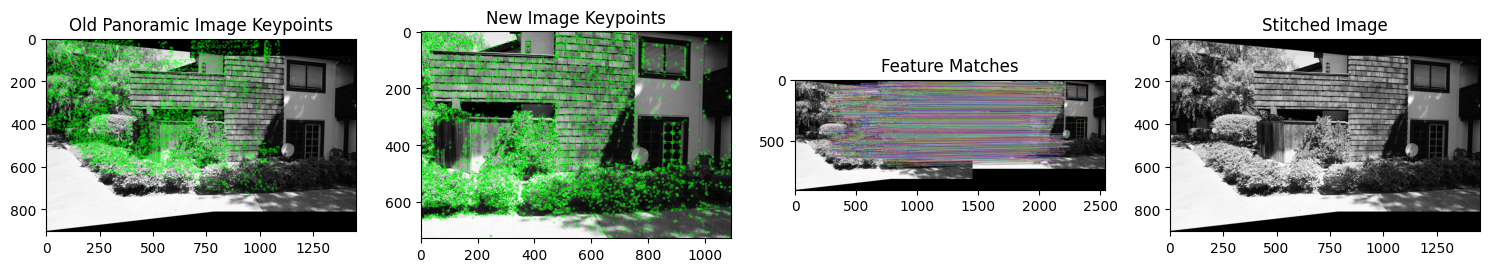

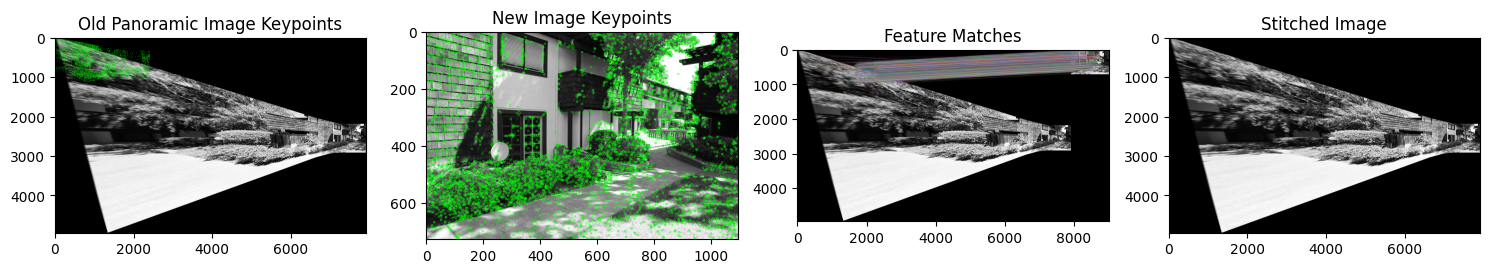

In [11]:
process_folder(os.path.join(dataset_directory, 'yard'), 4)

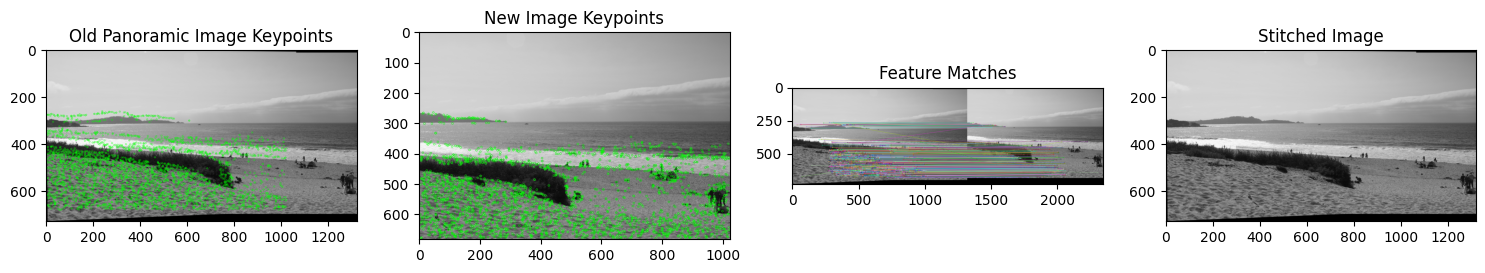

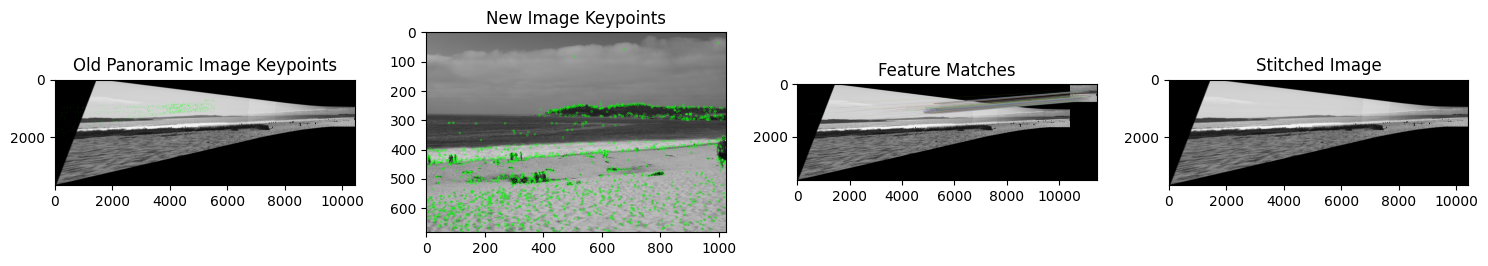

In [10]:
process_folder(os.path.join(dataset_directory, 'carmel'), 8)

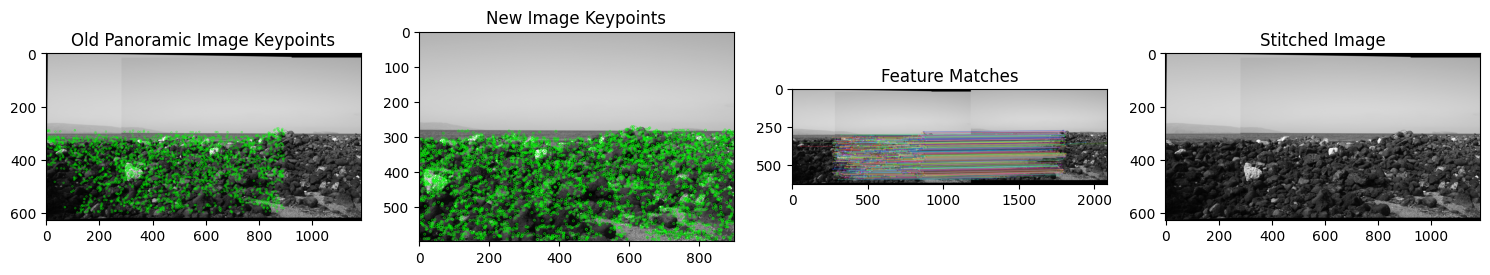

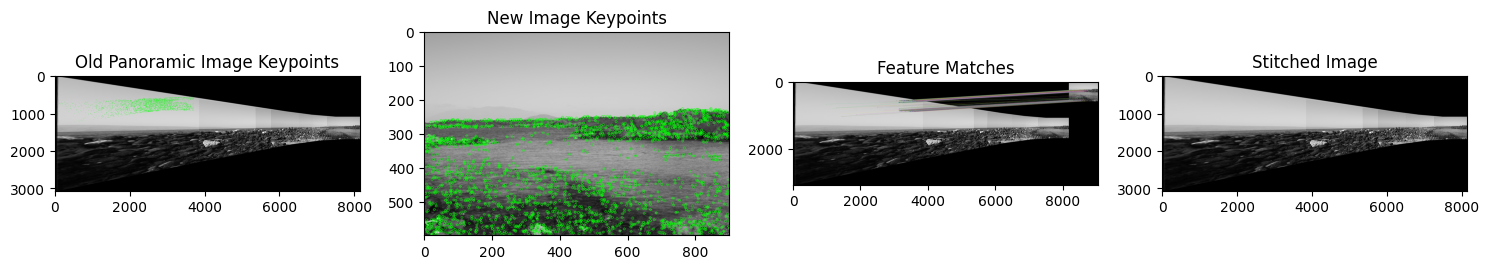

In [13]:
process_folder(os.path.join(dataset_directory, 'fishbowl'), 7)

# Rectifying Images to make them look good

In [11]:
def rectify_image(input_image_path, output_image_path, corners, target_width, target_height):
    # Read the image
    original_image = cv2.imread(input_image_path)

    # Convert corners to numpy array
    corners = np.array(corners, dtype=np.float32)

    # Define the desired rectangular shape
    rect_corners = np.array([[25, 25], [25, target_height], [target_width, target_height], [target_width, 25]], dtype=np.float32)

    # Calculate the perspective transformation matrix
    transformation_matrix = cv2.getPerspectiveTransform(corners, rect_corners)

    # Apply the perspective transformation to rectify the image
    rectified_image = cv2.warpPerspective(original_image, transformation_matrix, (target_width, target_height))

    # Save the rotated and rectified image
    cv2.imwrite(output_image_path, rectified_image)


def detect_corner_points(image_path, threshold=10):

    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Find the last non-black pixel in each row
    for row in reversed(range(image.shape[0])):
        non_black_pixels = np.where(image[row, :] > threshold)[0]
        if len(non_black_pixels) > 0:
            leftmost_bottom = (non_black_pixels[-1], row)
            break

    # Find leftmost top using the refined approach
    for col in range(image.shape[1]):
        non_black_pixels = np.where(image[:, col] > threshold)[0]
        if len(non_black_pixels) > 0:
            next_col = col + 1
            if next_col < image.shape[1]:
                next_non_black_pixels = np.where(image[:, next_col] > threshold)[0]
                if len(next_non_black_pixels) > 0:
                    # Compare with multiple subsequent columns to be more certain
                    compare_range = min(3, image.shape[1] - next_col)  # Compare with up to 3 subsequent columns
                    compare_results = [non_black_pixels[0] < np.where(image[:, next_col + i] > threshold)[0][0] for i in range(compare_range)]
                    if all(compare_results):
                        leftmost_top = (col, non_black_pixels[0])
                        break

    # Find the first non-black pixel in each column starting from the right side
    for col in reversed(range(image.shape[1])):
        non_black_pixels = np.where(image[:, col] > threshold)[0]
        if len(non_black_pixels) > 0:
            rightmost_top_col = col
            rightmost_top_row = non_black_pixels[0]
            break

    rightmost_top = (rightmost_top_col, rightmost_top_row)

    # Find the last non-black pixel in each column starting from the right side
    for col in reversed(range(rightmost_top_col, image.shape[1])):
        non_black_pixels = np.where(image[:, col] > threshold)[0]
        if len(non_black_pixels) > 0:
            rightmost_bottom = (col, non_black_pixels[-1])
            break

    return leftmost_top, leftmost_bottom, rightmost_bottom, rightmost_top

In [13]:
for folder in os.listdir(dataset_directory):
    panorama_path = os.path.join(dataset_directory,folder,"result.png")
    if os.path.exists(panorama_path):
        print(f"Rectifying Panorama Image {folder}")
        detected_corners = detect_corner_points(panorama_path)
        rectify_image(panorama_path, os.path.join(dataset_directory,folder,"result_rectified.png"), detected_corners, target_width=3000, target_height=900)

Rectifying Panorama Image carmel
Rectifying Panorama Image fishbowl
Rectifying Panorama Image goldengate
Rectifying Panorama Image hotel
Rectifying Panorama Image yard


Text(0.5, 1.0, 'Example Panoramic Image After Rectificiation')

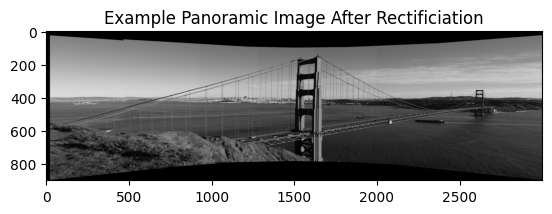

In [19]:
panoramic = cv2.imread(os.path.join(dataset_directory,"goldengate","result_rectified.png"))
plt.imshow(panoramic,cmap="gray")
plt.title("Example Panoramic Image After Rectificiation")

### You can find more example panoramic images before and after rectifiying in the report.

### These Images are not shown here due to the memory problem